In [1]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import os
import sys
from append_directories import *

home_folder = append_directory(2)
sys.path.append(home_folder)
from models import ncsnpp
from sde_lib import *
from configs.vp import ncsnpp_config
twisted_diffusion_folder = append_directory(5)
sys.path.append((twisted_diffusion_folder + "/twisted_diffusion/image_exp"))
from image_diffusion import my_smc_diffusion
from image_diffusion import my_feynman_kac_image_ddpm

In [2]:
device = "cuda:0"
config = ncsnpp_config.get_config()
score_model = (ncsnpp.NCSNpp(config)).to("cuda:0")
score_model.load_state_dict(th.load((home_folder + "/trained_score_models/vpsde/model2_beta_min_max_01_20_random50_masks.pth")))
score_model.eval()

/home/julia/Dropbox/diffusion/twisted_diffusion/sde_diffusion/masked/unparameterized/models/ncsnpp.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('sigmas', torch.tensor(get_sigmas(config)))


NCSNpp(
  (act): SiLU()
  (all_modules): ModuleList(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3-6): 4 x ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Dropout_0): Dropout(p=0.1, inplace=False)
      (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (7): ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): Gr

In [3]:


def construct_norm_matrix(minX, maxX, minY, maxY, n):
    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    X_matrix = (np.repeat(X, n**2, axis = 0)).reshape((n**2, n**2))
    Y_matrix = (np.repeat(Y, n**2, axis = 0)).reshape((n**2, n**2))
    longitude_squared = np.square(np.subtract(X_matrix, np.transpose(X_matrix)))
    latitude_squared = np.square(np.subtract(Y_matrix, np.transpose(Y_matrix)))
    norm_matrix = np.sqrt(np.add(longitude_squared, latitude_squared))
    return norm_matrix

def construct_exp_kernel(minX, maxX, minY, maxY, n, variance, lengthscale):

    norm_matrix = construct_norm_matrix(minX, maxX, minY, maxY, n)
    exp_kernel = variance*np.exp((-1/lengthscale)*norm_matrix)
    return(exp_kernel)

def generate_gaussian_process(minX, maxX, minY, maxY, n, variance, lengthscale, number_of_replicates,
                              seed_value):

    kernel = construct_exp_kernel(minX, maxX, minY, maxY, n, variance, lengthscale)
    np.random.seed(seed_value)
    z_matrix = np.random.multivariate_normal(np.zeros(n**2), np.identity(n**2), number_of_replicates)
    C = np.linalg.cholesky(kernel)
    y_matrix = np.matmul(np.transpose(C),
                                  np.transpose(z_matrix))
    
    gp_matrix = np.zeros((number_of_replicates,1,n,n))
    for i in range(0, y_matrix.shape[1]):
        gp_matrix[i,:,:,:] = y_matrix[:,i].reshape((1,n,n))
    return gp_matrix

#y is observed part of field
def p_mean_and_variance_from_score_via_mask(vpsde, score_model, device, masked_xt, mask, y, t):

    num_samples = masked_xt.shape[0]
    timestep = ((torch.tensor([t])).repeat(num_samples)).to(device)
    with th.no_grad():
        score = score_model(masked_xt, timestep)
    unmasked_p_mean = (1/th.sqrt(th.tensor(vpsde.alphas[t])))*(masked_xt + th.square(th.tensor(vpsde.sigmas[t]))*score)
    masked_p_mean = torch.mul((1-mask), unmasked_p_mean) + torch.mul(mask, y)
    unmasked_p_variance = (th.square(th.tensor(vpsde.sigmas[t])))*th.ones_like(masked_xt)
    masked_p_variance = torch.mul((1-mask), unmasked_p_variance)
    return masked_p_mean, masked_p_variance

def sample_with_p_mean_variance_via_mask(vpsde, score_model, device, masked_xt, mask, y, t, num_samples):

    p_mean, p_variance = p_mean_and_variance_from_score_via_mask(vpsde, score_model, device, masked_xt, mask, y, t)
    std = th.exp(0.5 * th.log(p_variance))
    noise = th.randn_like(masked_xt)
    #just to make sure that the masked values aren't perturbed by the noise, the variance should already be masked though
    masked_noise = torch.mul((1-mask), noise)
    sample = p_mean + std*masked_noise
    return sample


def posterior_sample_with_p_mean_variance_via_mask(vpsde, score_model, device, mask, y, n, num_samples):

    unmasked_xT = th.randn((num_samples, 1, n, n)).to(device)
    masked_xT = th.mul((1-mask), unmasked_xT) + torch.mul(mask, y)
    masked_xt = masked_xT
    for t in range((vpsde.N-1), 0, -1):
        masked_xt = sample_with_p_mean_variance_via_mask(vpsde, score_model, device, masked_xt,
                                                         mask, y, t, num_samples)

    return masked_xt



def visualize_sample(diffusion_sample, n):

    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(diffusion_sample.detach().cpu().numpy().reshape((n,n)), vmin = -2, vmax = 2)
    plt.show()

In [4]:
sdevp = VPSDE(beta_min=0.1, beta_max=20, N=1000)
n = 32
#mask = torch.ones((1,1,n,n)).to(device)
#mask[:,:,int(n/4):int(3*n/4),int(n/4):int(3*n/4)] = 0
p = .5
mask = (th.bernoulli(p*th.ones(1,1,n,n))).to(device)
num_samples = 1
minX = -10
maxX = 10
minY = -10
maxY = 10
variance = .4
lengthscale = 1.6
number_of_replicates = 1
seed_value = 43234
unmasked_y = (th.from_numpy(generate_gaussian_process(minX, maxX, minY, maxY, n, variance,
                                                     lengthscale, number_of_replicates,
                                                     seed_value))).to(device)
y = ((torch.mul(mask, unmasked_y)).to(device)).float()

In [41]:
sample = sample_with_p_mean_variance_via_mask(sdevp, score_model, device, masked_xt, mask, y, t, num_samples)

/tmp/ipykernel_15319/1135789620.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_mean = (1/th.sqrt(th.tensor(vpsde.alphas[t])))*(masked_xt + th.square(th.tensor(vpsde.sigmas[t]))*score)
/tmp/ipykernel_15319/1135789620.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_variance = (th.square(th.tensor(vpsde.sigmas[t])))*th.ones_like(masked_xt)


/tmp/ipykernel_12266/3043536424.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_mean = (1/th.sqrt(th.tensor(vpsde.alphas[t])))*(masked_xt + th.square(th.tensor(vpsde.sigmas[t]))*score)
/tmp/ipykernel_12266/3043536424.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_variance = (th.square(th.tensor(vpsde.sigmas[t])))*th.ones_like(masked_xt)


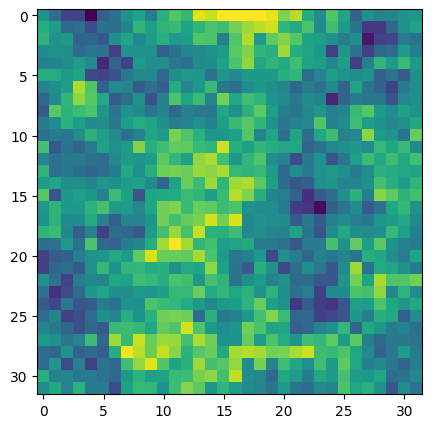

In [6]:
n = 32
num_samples = 1
diffusion_sample = posterior_sample_with_p_mean_variance_via_mask(sdevp, score_model,
                                                                  device, mask, y, n,
                                                                  num_samples)
visualize_sample(diffusion_sample, n)

In [7]:
n = 32
num_samples = 5
diffusion_samples = posterior_sample_with_p_mean_variance_via_mask(sdevp, score_model,
                                                                  device, mask, y, n,
                                                                  num_samples)

/tmp/ipykernel_12266/3043536424.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_mean = (1/th.sqrt(th.tensor(vpsde.alphas[t])))*(masked_xt + th.square(th.tensor(vpsde.sigmas[t]))*score)
/tmp/ipykernel_12266/3043536424.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_p_variance = (th.square(th.tensor(vpsde.sigmas[t])))*th.ones_like(masked_xt)


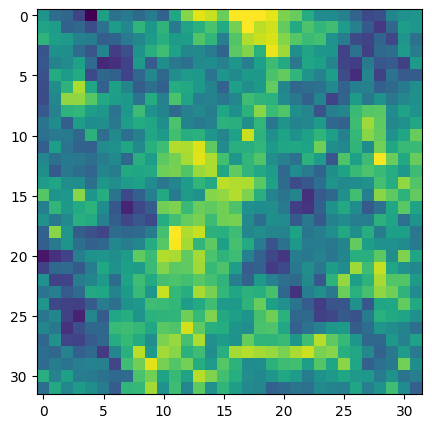

In [8]:
visualize_sample(diffusion_samples[0,:,:,:], n)

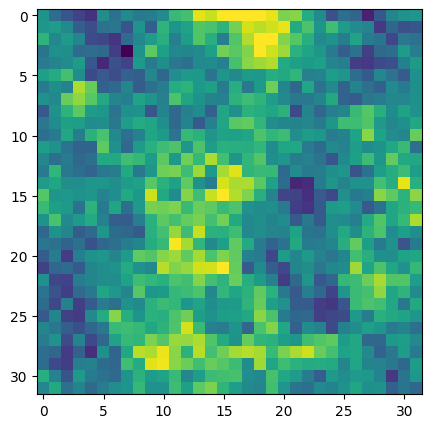

In [9]:
visualize_sample(diffusion_samples[1,:,:,:], n)

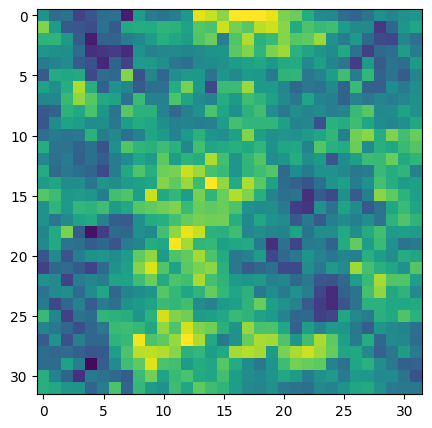

In [10]:
visualize_sample(diffusion_samples[2,:,:,:], n)

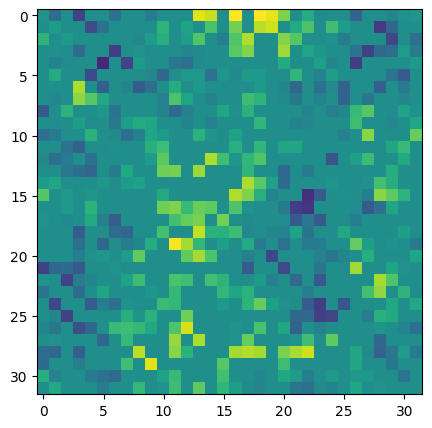

In [11]:
visualize_sample(y, n)

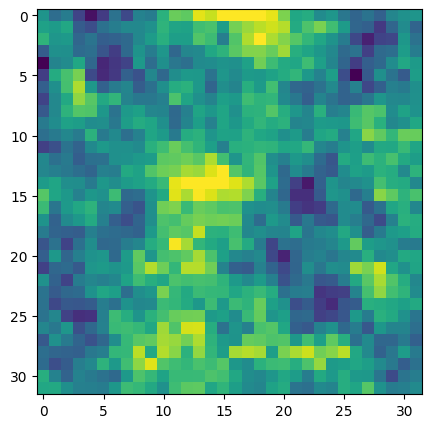

In [12]:
visualize_sample(unmasked_y, n)

In [ ]:
num_samples = 5
diffusion_sample = posterior_sample_with_p_mean_variance_via_mask(sdevp, score_model,
                                                                  device, mask, y, n,
                                                                  num_samples)